<font size="6">Feature Engineering and Modelling on Text Data</font> 

In this notebook, we calculate features on data streamed from seppe.net in Preprocessing.ipynb. We calculate the following features on the data and columns in the extracted wiki_df dataframe:

- `TF-IDF`: Term Frequency - Inverse Document Frequency matrix is a feature which measures the occurrence of words normalized by their overall occurrence in the entire document corpus. We use this on the raw edits applied to each Wikipedia article to help gather features as to which words and terms in overall edits may lead to vandal edits or otherwise.
- `LDA`: Latent Dirichlet Analysis is a technique used in automated topic discovery. We use this on the overall Wiki text before edit to discover the original topic of the piece. The reason for using this feature is that some topics may be more susceptible to vandalism than others, such as political articles, for example.
- `Leichtenstein Distance`: This is used again on the raw edits to quantify the size of the edit. Usually large edits might correspond to large erasures or changes in a document text indicating vandalism and censoring of data from the public.

#  Import libraries

In [1]:
# Perform data transformations
from pyspark.sql.functions import lit
import pandas as pd
import numpy as np

# Machine learning libraries
from pyspark.ml.feature import HashingTF
from pyspark.ml.feature import IDF
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StringIndexer 
from pyspark.ml.feature import NGram
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

# visualize
import matplotlib.pyplot as plt

# performance evaluation
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import cohen_kappa_score

# other
from nltk.corpus import stopwords

# own functions
from functions.performance.metrics import plot_confusion_matrix 


Bad key "text.kerning_factor" on line 4 in
C:\Users\Pieter-Jan\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# Global variables

In [2]:
# avaialble plotting styles
print(plt.style.available)
plt.style.use('bmh')

# A) ALL DATA
LOAD_CLEAN_DATA_PATH = "../../output/output_data_cleaning.parquet"

# B) SUBSET DATA
# LOAD_CLEAN_DATA_PATH = "../output/output_data_cleaning.parquet" 

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test', '_classic_test_patch']


# Load output from *preprocessing.ipynb*

you can either 
 - **option A**: run `preprocessing.ipynb` and perform the steps below to end up to the `final_df`
 - **option B** just import the data via: `spark.read.parquet("../output/output_preprocessing.parquet")`
 
**TODO**
 
 - Evaluate feature engineering steps on a larget part of the data, the subset dataset containg approx. 800 observations and approx 300 observations after downsampling.
 - Train `final model` on **all data**.
 

## Option A

In [3]:
#  %run "preprocessing.ipynb"

In [4]:
# path = "../data/subset/*" (this is the path to the subset data)

# wiki_df = get_wiki_df(path="../data/subset/*")

# clean_df = get_clean_df(wiki_df)

# #In order to get the actual difference column
# df_with_difference = get_difference_column(clean_df)
# final_df = split_difference_into_removed_added(df_with_difference)

In [5]:
# final_df.head()

## Option B

In [6]:
final_df = spark.read.parquet(LOAD_CLEAN_DATA_PATH)

#  Balance data using *stratified sampling*

We do this to ease the memory usage of the TF-IDF. In any case, the data is highly imbalanced, with a current distribution of:

- safe: 30333 (~86%)
- unsafe: 4136 (~13.2%)
- vandal: 270 (~0.8%)

It is better to rebalance this by **downsampling** the `safe` class and keeping the others.

**TODO**
 - check effect on performance: does it improves/worsens or really doesn't matter?

In [7]:
def get_stratified_sample(df, fractions, categorical_class="label", random_state=42):
    """
    This function creates a stratified sample based on thresholds specified on a categorical class
    The aim of this is to balance a dataset more evenly by reducing the size of over-prepresented classes.

    Args:
        df: pyspark dataframe with data to be stratified sampled
        fractions: a dictionary of fractions for each category in the categorical variable
        categorical_class: the variable on which to perform stratified sampling
        random_state: default = 42. Set the seed for reproducibility
    Returns:
        df: a pyspark dataframe which has been stratified sampled based on the above criteria.
    """
    auto_fractions = df.select("{}".format(categorical_class)).distinct(
    ).withColumn("fraction", lit(1.0)).rdd.collectAsMap()
    #fractions = {'safe': 0.1, 'unsafe': 1.0, 'vandal':1.0}
    # override default 1.0 non-samples with classes which need to be subsampled
    for frac in fractions.items():
        key = frac[0]
        frac_value = frac[1]
        auto_fractions[key] = frac_value

    seed = random_state
    sampled_df = df.stat.sampleBy(categorical_class, auto_fractions, seed)
    return sampled_df

## before downsampling

In [8]:
final_df.groupBy("label").count().show()

+------+-----+
| label|count|
+------+-----+
|  safe|30333|
|unsafe| 4136|
|vandal|  270|
+------+-----+



## after downsampling

In [9]:
sampled_df = get_stratified_sample(df=final_df, fractions={'safe': 0.15})
sampled_df.groupBy("label").count().show()

+------+-----+
| label|count|
+------+-----+
|  safe| 4581|
|unsafe| 4136|
|vandal|  270|
+------+-----+



#  Split in training and test set

preserve balance of classes by performing a **stratisfied split** to get a representive test set

**IMPORTANT**
- The **training set** is to train the model
-  **validation set** is used to find good parameters
- The **test set** is to evaluate performance (generalization error) of the final chosen model
- When you stream the data: that's model deployment (I don't really consider this as test data), this is actual live incoming data

In [10]:
# Taking 60% train, 20 % val, 20% test
split_ratio_1 = 0.80
split_ratio_2 = 0.75 # 0.75 of 0.8  =  0.60

train_val = sampled_df.sampleBy("label",
                            fractions={'unsafe': split_ratio_1, 'safe': split_ratio_1, 'vandal': split_ratio_1}, seed=10)

# training data
train = train_val.sampleBy("label",
                            fractions={'unsafe': split_ratio_2, 'safe': split_ratio_2, 'vandal': split_ratio_2}, seed=10)

# Subtracting 'train' from 'train_val' to get validation set
validaton = train_val.subtract(train)

# Subtracting 'train_val' from original 'data' to get test set
test = sampled_df.subtract(train_val)

In [11]:
train.groupBy("label").count().show()

+------+-----+
| label|count|
+------+-----+
|  safe| 2773|
|unsafe| 2461|
|vandal|  164|
+------+-----+



In [12]:
validaton.groupBy("label").count().show()

+------+-----+
| label|count|
+------+-----+
|  safe|  884|
|unsafe|  840|
|vandal|   53|
+------+-----+



In [13]:
test.groupBy("label").count().show()

+------+-----+
| label|count|
+------+-----+
|  safe|  923|
|unsafe|  826|
|vandal|   52|
+------+-----+



# Construct pipeline

 - Spark API pipeline: https://spark.apache.org/docs/latest/ml-pipeline.html (very similar to scikit-learn)
 - Spark API extact features (e.g. *TF-IDF, N-Gram*): https://spark.apache.org/docs/latest/ml-features.html 
 - Spark API models: https://spark.apache.org/docs/latest/ml-classification-regression.html 
 
**TODO**:  
 - Try out different feature engineering steps and evaluate

## TF-IDF Features (new and old text)

Term Frequency - Inverse Document Frequency (TF-IDF) is a technique used to build features out of text documents which have theoretically infinite dimensionality without feature reduction techniques such as this. The term-frequency is the step where we take the tokenized words from the text documents and hash them to a finite feature space. The resulting vectors represent a single document of text. For example, the text 'the brown fox' will hash to a vector of specified length, say 5, such that the result of the hash yields [1,0,2,0,0]. In the case of Spark, the hash used is MurmurHash 3.

However, in a large text corpus, some words will be very present (e.g. “the”, “a”, “is”) hence carrying very little meaningful information about the actual contents of the document. If we were to feed the direct count data directly to a classifier those very frequent terms would shadow the frequencies of rarer yet more interesting terms.

In order to re-weight the count features into floating point values suitable for usage by a classifier it is very common to incorporate the document frequency of occurrence as a weight or normalization to the term-frequencies mentioned above. Hence, TF-IDF.

In [14]:
# define stops words
# nltk.download('stopwords')
STOP_WORDS = list(set(stopwords.words('english')))

### *A) clean_new_text*

In [15]:
# Carrying out the Tokenization of the text documents (splitting into words)
tokenizer_new = Tokenizer(inputCol="clean_new_text",
                          outputCol="clean_new_tokenised_text")
stopwordsremover_new = StopWordsRemover(
    inputCol=tokenizer_new.getOutputCol(), stopWords = STOP_WORDS, outputCol='words_clean_new')

# hashing is irreversible whereas counting is
hashingTF_new = HashingTF(inputCol=stopwordsremover_new.getOutputCol(
), outputCol="tf_features_clean_new", numFeatures=2000)

# cv=CountVectorizer(inputCol="words", outputCol="tf_features", vocabSize=300, minDF=2.0)
idf_new = IDF(inputCol=hashingTF_new.getOutputCol(),
              outputCol="feature_clean_new", minDocFreq=5)

### *B) clean_old_text*

In [16]:
# Carrying out the Tokenization of the text documents (splitting into words)
tokenizer_old = Tokenizer(inputCol="clean_old_text",
                          outputCol="clean_old_tokenised_text")
stopwordsremover_old = StopWordsRemover(
    inputCol=tokenizer_old.getOutputCol(), stopWords = STOP_WORDS, outputCol='words_clean_old')

# hashing is irreversible whereas counting is
hashingTF_old = HashingTF(inputCol=stopwordsremover_old.getOutputCol(
), outputCol="tf_features_clean_old", numFeatures=2000)

# cv=CountVectorizer(inputCol="words", outputCol="tf_features", vocabSize=300, minDF=2.0)
idf_old = IDF(inputCol=hashingTF_old.getOutputCol(),
              outputCol="feature_clean_old", minDocFreq=5)

## N-Gram Features on Text Differences (Added/Removed)

Here we extract n-gram features from the text differences (text added or removed). The goal is from these simple combinations of words to extract usable features for modelling. Since the words are unordered, an n-gram model is appropriate, as it itself is not necessarily order-preserving in its selection of words.

We select $n = 2$ for simplicity of the method. Additionally, we optionally apply feature hashing to the resulting n-grams.

### *A) added_words*

In [17]:
ngram_added = NGram(n=2, inputCol="added_words", outputCol="ngrams_added")

# Carrying out the StopWords Removal for TF-IDF
stopwordsremover_added = StopWordsRemover(
    inputCol=ngram_added.getOutputCol(), stopWords = STOP_WORDS, outputCol='words_added')
hashingTF_added = HashingTF(inputCol=stopwordsremover_added.getOutputCol(
), outputCol="feature_added", numFeatures=2000)

### *B) removed_words*

In [18]:
ngram_removed = NGram(n=2, inputCol="removed_words",
                      outputCol="ngrams_removed")

# Carrying out the StopWords Removal for TF-IDF
stopwordsremover_removed = StopWordsRemover(
    inputCol=ngram_removed.getOutputCol(), stopWords = STOP_WORDS, outputCol='words_removed')
hashingTF_removed = HashingTF(inputCol=stopwordsremover_removed.getOutputCol(
), outputCol="feature_removed", numFeatures=2000)

##  Add all steps and define model

You can change the model to whathever model you want to try
see SPARK API for all models:

- Spark API models: https://spark.apache.org/docs/latest/ml-classification-regression.html 

**TODO**
- Explore different models

In [19]:
# add all features to a vector assembler and call it features (default names for most models)
assembler = VectorAssembler(
    inputCols=["feature_clean_new", "feature_clean_old",
               "feature_removed", "feature_added"],
    outputCol="features")

# make target numeric
label_stringIdx = StringIndexer(inputCol="label", outputCol="target")


# define model
nb = NaiveBayes(smoothing=1.0, modelType="multinomial",
                featuresCol='features', labelCol='target')

# add pipeline steps
pipeline = Pipeline(stages=[tokenizer_new, stopwordsremover_new, hashingTF_new, idf_new,
                            tokenizer_old, stopwordsremover_old, hashingTF_old, idf_old,
                            ngram_removed, stopwordsremover_removed, hashingTF_removed,
                            ngram_added, stopwordsremover_added, hashingTF_added,
                            assembler, label_stringIdx, nb])

# Train fit model (pipeline)

In [20]:
# Fit the pipeline to training documents.
model_train = pipeline.fit(train)

In [21]:
pred_train = model_train.transform(train)
pred_train.select("target","label", "prediction").show(5)

+------+-----+----------+
|target|label|prediction|
+------+-----+----------+
|   0.0| safe|       0.0|
|   0.0| safe|       0.0|
|   0.0| safe|       0.0|
|   0.0| safe|       0.0|
|   0.0| safe|       0.0|
+------+-----+----------+
only showing top 5 rows



## This is used for decoding the numeric predictions values back to the original labels

In [22]:
label_str = list(pred_train.select("label").toPandas()['label'].unique())
label_num = [0,1,2]
map_num_2_str = dictionary = dict(zip(label_num, label_str))
print(map_num_2_str)

{0: 'safe', 1: 'unsafe', 2: 'vandal'}


# Evaluation on training data


## A) Confusion matrix

In [23]:
class_names = label_str
y_true_train = pred_train.select("label").toPandas()
y_pred_train = pred_train.select("prediction").toPandas()
y_pred_train = y_pred_train['prediction'].map(map_num_2_str, na_action='ignore')

# make confusion matrix
cnf_matrix_train = confusion_matrix(y_true=y_true_train, y_pred=y_pred_train, labels=class_names)
pd.DataFrame(cnf_matrix_train, columns=class_names, index=class_names)

,safe,unsafe,vandal
safe,1467,965,341
unsafe,535,1592,334
vandal,43,32,89


Confusion matrix, without normalization
        safe  unsafe  vandal
safe    1467     965     341
unsafe   535    1592     334
vandal    43      32      89


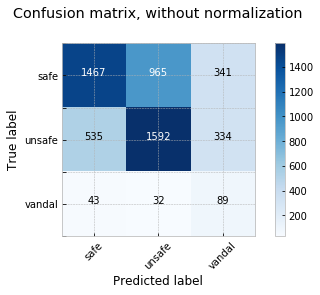

In [24]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_train, classes=class_names, normalize=False,
                      title='Confusion matrix, without normalization')

# I need to fix this manually, we should fix this in the future (this look bit clumpsy)
plt.yticks([2.5,2,1.5,1,0.5,0,-.5],labels=["",label_str[2],"",label_str[1],"",label_str[0]]);

## B) Summary metrics

- Acc
- F1
- Matthews correlation coefficient
- Cohen kappa
- AU ROC

In [26]:
# Acc and F1
evaluator_acc = MulticlassClassificationEvaluator(
    predictionCol="prediction", labelCol='target', metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(
    predictionCol="prediction", labelCol='target', metricName="f1")

print(f"Accuracy: {round(evaluator_acc.evaluate(pred_train), 4)}")
print(f"F1 score: {round(evaluator_f1.evaluate(pred_train), 4)}")

Accuracy: 0.5832
F1 score: 0.6061


In [27]:
mcc_train = matthews_corrcoef(y_true_train, y_pred_train)
kappa_train = cohen_kappa_score(y_true_train, y_pred_train)

print(f" MCC: {mcc_train}")
print(f" Kappa: {kappa_train}")

 MCC: 0.2928435579301112
 Kappa: 0.2843293012689919


In [28]:
# AUC
results = pred_train.select(['probability', 'target'])
# prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)

metrics = metric(scoreAndLabels)
print("Area under ROC score is : ", round(metrics.areaUnderROC,4))

Area under ROC score is :  0.7256


# Performance on validation set
 - check for reasonable good paramater values

In [29]:
pred_val = model_train.transform(validaton)
pred_val.select("target","label", "probability", "prediction").show(5)

+------+-----+--------------------+----------+
|target|label|         probability|prediction|
+------+-----+--------------------+----------+
|   0.0| safe|[1.0,3.4830503292...|       0.0|
|   0.0| safe|[0.99974441711387...|       0.0|
|   0.0| safe|[0.96956893967898...|       0.0|
|   0.0| safe|[0.99997787471010...|       0.0|
|   0.0| safe|[2.60289546649247...|       1.0|
+------+-----+--------------------+----------+
only showing top 5 rows



## A) Confusion Matrix

In [30]:
y_true_val = pred_val.select("label").toPandas()
y_pred_val = pred_val.select("prediction").toPandas()
y_pred_val = y_pred_val['prediction'].map(map_num_2_str, na_action='ignore')

# make confusion matrix
cnf_matrix_val = confusion_matrix(y_true=y_true_val, y_pred=y_pred_val, labels=class_names)
pd.DataFrame(cnf_matrix_val, columns=class_names, index=class_names)

,safe,unsafe,vandal
safe,416,373,95
unsafe,198,492,150
vandal,12,33,8


Confusion matrix, without normalization
        safe  unsafe  vandal
safe     416     373      95
unsafe   198     492     150
vandal    12      33       8


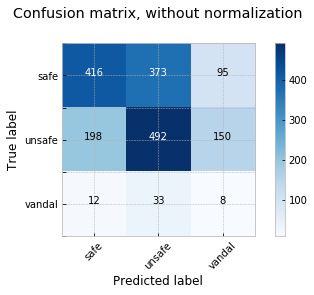

In [31]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_val, classes=class_names, normalize=False,
                      title='Confusion matrix, without normalization')

# I need to fix this manually, we should fix this in the future (this look bit clumpsy)
plt.yticks([2.5,2,1.5,1,0.5,0,-.5],labels=["",label_str[2],"",label_str[1],"",label_str[0]]);

## B) Summary Metrics

- Acc
- F1
- Matthews correlation coefficient
- Cohen kappa
- AU ROC

In [32]:
print(f"Accuracy: {round(evaluator_acc.evaluate(pred_val), 4)}")
print(f"F1 score: {round(evaluator_f1.evaluate(pred_val), 4)}")

Accuracy: 0.5155
F1 score: 0.5433


In [33]:
# mcc and kappa
mcc_val = matthews_corrcoef(y_true_val, y_pred_val)
kappa_val = cohen_kappa_score(y_true_val, y_pred_val)

print(f" MCC: {mcc_val}")
print(f" Kappa: {kappa_val}")

 MCC: 0.17245020891125099
 Kappa: 0.16694779964891948


In [34]:
# AUC
results = pred_val.select(['probability', 'target'])
# prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)

metrics = metric(scoreAndLabels)
print("Area under ROC score is : ", round(metrics.areaUnderROC,4))

Area under ROC score is :  0.6643


# Performance of final model (pipeline) on test set


**Important**
 - Only use this dataset once you decided on your final model.
 - This is only to get and idea of your models performance in real live (when we start streaming)
 - !! Do never make any decision on the test data, only on the validation data

## First fit model on both training and validation data

In [35]:
model_train_val = pipeline.fit(train_val)

In [36]:
pred_test = model_train_val.transform(test)
pred_test.select("target","label", "probability", "prediction").show(5)

+------+------+--------------------+----------+
|target| label|         probability|prediction|
+------+------+--------------------+----------+
|   0.0|  safe|[0.99997883933487...|       0.0|
|   0.0|  safe|[0.50023576558081...|       0.0|
|   0.0|  safe|[1.0,5.8550725556...|       0.0|
|   0.0|  safe|[0.98466479846764...|       0.0|
|   1.0|unsafe|[0.65595817051687...|       0.0|
+------+------+--------------------+----------+
only showing top 5 rows



## A) Confusion Matrix

In [37]:
class_names = ['unsafe','safe', 'vandal']
y_true_test = pred_test.select("label").toPandas()
y_pred_test = pred_test.select("prediction").toPandas()
y_pred_test = y_pred_test['prediction'].map(map_num_2_str, na_action='ignore')

# make confusion matrix
cnf_matrix_test = confusion_matrix(y_true=y_true_test, y_pred=y_pred_test, labels=class_names)
pd.DataFrame(cnf_matrix_test, columns=class_names, index=class_names)

,unsafe,safe,vandal
unsafe,495,200,131
safe,364,428,131
vandal,28,9,15


Confusion matrix, without normalization
        unsafe  safe  vandal
unsafe     495   200     131
safe       364   428     131
vandal      28     9      15


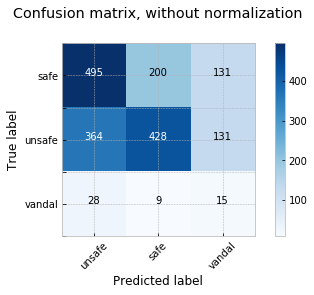

In [38]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_test, classes=class_names, normalize=False,
                      title='Confusion matrix, without normalization')

# I need to fix this manually, we should fix this in the future (this look bit clumpsy)
plt.yticks([2.5,2,1.5,1,0.5,0,-.5],labels=["",label_str[2],"",label_str[1],"",label_str[0]]);

## B) Summary Metrics

- F1
- Matthews correlation coefficient
- Cohen kappa
- AU ROC

In [39]:
# Acc and F1
print(f"Accuracy: {round(evaluator_acc.evaluate(pred_test), 4)}")
print(f"F1 score: {round(evaluator_f1.evaluate(pred_test), 4)}")

Accuracy: 0.5208
F1 score: 0.5489


In [40]:
mcc_test = matthews_corrcoef(y_true_test, y_pred_test)
kappa_test = cohen_kappa_score(y_true_test, y_pred_test)

print(f" MCC: {mcc_test}")
print(f" Kappa: {kappa_test}")

 MCC: 0.1930229747084244
 Kappa: 0.18564600772090722


In [41]:
# AUC
results = pred_test.select(['probability', 'target'])
# prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)

metrics = metric(scoreAndLabels)
print("Area under ROC score is : ", round(metrics.areaUnderROC,4))

Area under ROC score is :  0.6516


# Train final model (pipline) on all data and save

**IMPORTANT**

- train your final model on **ALL DATA** using the parameters found above

In [42]:
final_model = pipeline.fit(sampled_df)

In [43]:
final_model.write().overwrite().save("../output/models/naive_bayes")